<a href="https://colab.research.google.com/github/MohamedAbuAmira/ML-DL-Examples/blob/master/Text_Recognition_with_EAST_and_Tesseract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* By Mohammed Abu Amira 
* Github: https://github.com/MohamedAbuAmira

* Linkedin:  https://www.linkedin.com/in/mohamedtayser94/

Check my work on pytesseract 
https://github.com/MohamedAbuAmira/ML-DL-Examples/blob/master/pytesseract(OCR).ipynb

I will use some of the images to show both text detection with the EAST method and text recognition with Tesseract 4. Let's see text detection and recognition in action in the following code.

# Installation


In [ ]:
!pip install pytesseract
!sudo apt install tesseract-ocr

  Created wheel for pytesseract: filename=pytesseract-0.3.5-py2.py3-none-any.whl size=13405 sha256=0e9e616417b9047f1cdd26614705201de0011188e6503b48cc7f3b7ac393d444
  Stored in directory: /root/.cache/pip/wheels/4c/57/f5/4e60154cc0cfb584373ec7922766e67d00f34879c21ed73f14
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 

In [ ]:
#Make sure you are installing both libraries together.
try:
 from PIL import Image
except ImportError:
 import Image
import cv2
from google.colab.patches import cv2_imshow
import pytesseract
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

In [ ]:
!pip install imutils
from imutils.object_detection import non_max_suppression


In [ ]:
# import text_detection from Kaggle datasets
# this is the file having the pre-trained EAST detector model.
# How to use Kaggle dataset in Colab: https://towardsdatascience.com/how-to-use-kaggle-datasets-in-google-colab-bca5e452a676
!pip install -q kaggle
#Then we need to upload kaggle.json file.
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedtayser","key":"2d27b20b0fbd11d6c0066e3997681dab"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d mlwhiz/text-detection

100% 87.0M/87.2M [00:01<00:00, 79.9MB/s]
100% 87.2M/87.2M [00:01<00:00, 69.4MB/s]


In [ ]:
import os
path = os.path.join('./', "text-detection") 
os.mkdir(path) 

In [ ]:
import zipfile
with zipfile.ZipFile("/content/text-detection.zip", 'r') as zip_ref:
    zip_ref.extractall(path)

# Creating argument dictionary

In [ ]:
os.listdir(path)

['east_text_detection.pb', 'Example-images', 'example-images']

In [ ]:
from os import listdir
from os.path import isfile, join

path_to_images="/content/text-detection/Example-images/Example-images/"

# Get all images paths
image_paths = [os.path.join(path_to_images,f) for f in listdir(path_to_images) if isfile(join(path_to_images, f))]

In [ ]:
image_paths

['/content/text-detection/Example-images/Example-images/ex27.jpg',
 '/content/text-detection/Example-images/Example-images/ex24.jpg',
 '/content/text-detection/Example-images/Example-images/ex08.jpg',
 '/content/text-detection/Example-images/Example-images/ex30.jpeg',
 '/content/text-detection/Example-images/Example-images/ex12.jpg',
 '/content/text-detection/Example-images/Example-images/ex17.jpg']

In [ ]:
path_to_EAST= os.path.join(path, "east_text_detection.pb") 

In [ ]:
#Creating argument dictionary for the default arguments needed in the code. 
args = {"image":image_paths[0], 
        "east":path_to_EAST, 
        "min_confidence":0.5, 
        "width":320, 
        "height":320}

* **image**: The location of the input image for text detection & recognition.
* **east**: The location of the file having the pre-trained EAST detector model.
* **min-confidence**: Min probability score for the confidence of the geometry shape predicted at the location.
* **width**: Image width should be multiple of 32 for the EAST model to work well.
* **height**: Image height should be multiple of 32 for the EAST model to work well.

# Image processing


In [211]:
# Give location of the image to be read.
# "Example-images/ex24.jpg" image is being loaded here. 

def image_processing(image_path):
		args['image']= image_path
		image = cv2.imread(args['image'])

		# Saving a original image and shape
		orig = image.copy()
		(origH, origW) = image.shape[:2]

		# set the new height and width to default 320 by using args #dictionary.  
		(newW, newH) = (args["width"], args["height"])

		# Calculate the ratio between original and new image for both height and weight. 
		# This ratio will be used to translate bounding box location on the original image. 
		rW = origW / float(newW)
		rH = origH / float(newH)
		ratio_dim= [rW, rH]

		# resize the original image to new dimensions
		image = cv2.resize(image, (newW, newH))
		(H, W) = image.shape[:2]

		# construct a blob from the image to forward pass it to EAST model
		blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
			(123.68, 116.78, 103.94), swapRB=True, crop=False)
	
		return (orig, ratio_dim, blob)

# Define a function to pre-trained EAST model and forward pass


In [212]:
def EAST_model_results(blob_):
    ## Loading Pre-trained EAST model and defining output layers
    
    # load the pre-trained EAST model for text detection 
    net = cv2.dnn.readNet(args["east"])

    # We would like to get two outputs from the EAST model. 
    # 1. Probabilty scores for the region whether that contains text or not. 
    # 2. Geometry of the text -- Coordinates of the bounding box detecting a text
    # The following two layer need to pulled from EAST model for achieving this. 
    layerNames = [
      "feature_fusion/Conv_7/Sigmoid",
      "feature_fusion/concat_3"]

    ## Forward pass the image through EAST model

    # Forward pass the blob from the image to get the desired output layers
    net.setInput(blob_)
    (scores, geometry) = net.forward(layerNames)

    return (scores, geometry)

# Decode bounding box from EAST model prediction

In [213]:
## Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
    (numR, numC) = prob_score.shape[2:4]
    boxes = []
    confidence_val = []

    # loop over rows
    for y in range(0, numR):
      scoresData = prob_score[0, 0, y]
      x0 = geo[0, 0, y]
      x1 = geo[0, 1, y]
      x2 = geo[0, 2, y]
      x3 = geo[0, 3, y]
      anglesData = geo[0, 4, y]

      # loop over the number of columns
      for i in range(0, numC):
        if scoresData[i] < args["min_confidence"]:
          continue

        (offX, offY) = (i * 4.0, y * 4.0)

        # extracting the rotation angle for the prediction and computing the sine and cosine
        angle = anglesData[i]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # using the geo volume to get the dimensions of the bounding box
        h = x0[i] + x2[i]
        w = x1[i] + x3[i]

        # compute start and end for the text pred bbox
        endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
        endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
        startX = int(endX - w)
        startY = int(endY - h)

        boxes.append((startX, startY, endX, endY))
        confidence_val.append(scoresData[i])

    # return bounding boxes and associated confidence_val
    return (boxes, confidence_val)

Only decoding horizontal bounding boxes. Decoding rotating bounding boxes from the scores and geometry is more complex.


# Getting final bounding boxes after non max suppression

In [214]:
def final_bounding_box(scores, geometry):

    # Find predictions and  apply non-maxima suppression
    (boxes, confidence_val) = predictions(scores, geometry)
    boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

    return boxes

# Generating list with bounding box coordinates and recognized text in the boxes

In [215]:
## Text Detection and Recognition 

def text_Detection_Recognition(boxes, orignal_img, ratio_dim):
    # initialize the list of results
    # initialize the list of results
    results = []

    # loop over the bounding boxes to find the coordinate of bounding boxes
    for (startX, startY, endX, endY) in boxes:
      # scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
      startX = int(startX * ratio_dim[0])       # ratio_dim[0]==rW
      startY = int(startY * ratio_dim[1])       # ratio_dim[1]==rH
      endX = int(endX * ratio_dim[0])           # ratio_dim[0]==rW
      endY = int(endY * ratio_dim[1])           # ratio_dim[1]==rH

      # extract the region of interest
      r = orignal_img[startY:endY, startX:endX]

      #configuration setting to convert image to string.  
      configuration = ("-l eng --oem 1 --psm 8")
        ##This will recognize the text from the image of bounding box
      text = pytesseract.image_to_string(r, config=configuration)

      # append bbox coordinate and associated text to the list of results 
      results.append(((startX, startY, endX, endY), text))

    return results

# Display image with bounding box and recognized text

In [216]:
def disply_results(results, orignal_img):
    # Display the image with bounding box and recognized text
    orig_image = orignal_img.copy()

    # Moving over the results and display on the image
    for ((start_X, start_Y, end_X, end_Y), text) in results:
      # display the text detected by Tesseract
      print("{}\n".format(text))

      # Displaying text
      text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
      cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
        (0, 255, 0), 3)
      cv2.putText(orig_image, text, (start_X, start_Y - 30),
        cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,255, 0), 3)
      
    plt.figure(figsize=(20,10)) 
    plt.subplot(1,2,2)
    plt.imshow(orig_image)
    plt.title('Output')

    plt.subplot(1,2,1)
    plt.imshow(orignal_img)
    plt.title('Original Image')
    plt.show()



---



In [217]:
def detection_and_recognition_one_images(img_path):
    orig_image, ratio_dim, blob= image_processing(image_path=img_path)
    scores, geometry=EAST_model_results(blob_=blob)

    boxes=final_bounding_box(scores, geometry)
    results=text_Detection_Recognition(boxes, orignal_img=orig_image, ratio_dim=ratio_dim)
    disply_results(results, orignal_img=orig_image)


ERICSSON


MOTOROLA


NOKIA




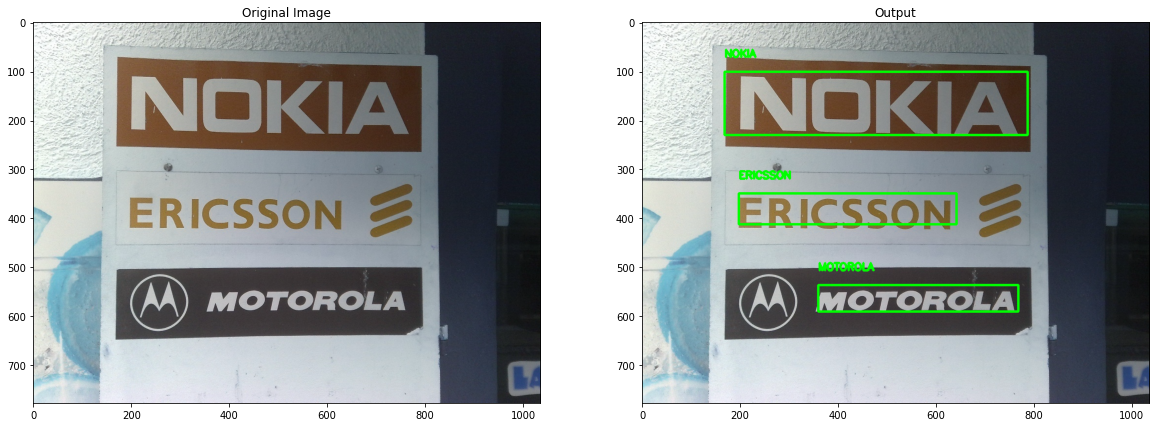

In [218]:
detection_and_recognition_one_images(img_path=image_paths[0])

STARBUCKS


COFFEE




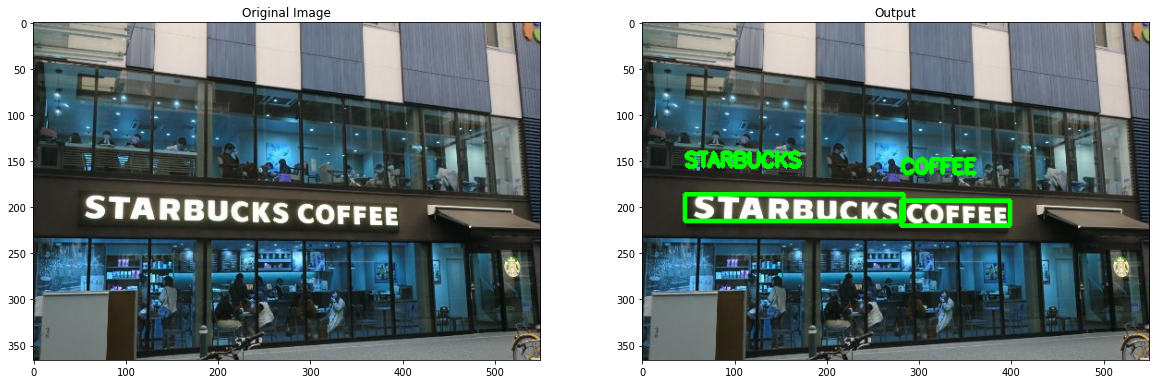

In [219]:
detection_and_recognition_one_images(img_path=image_paths[1])


Yeh,


End


Center


Auke


Road


City


of


ih


12




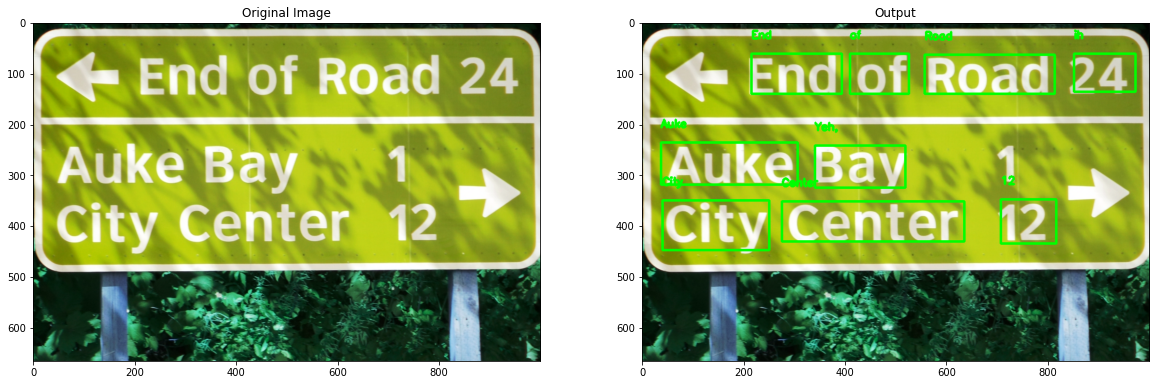

In [220]:
detection_and_recognition_one_images(img_path=image_paths[2])


NOT


SCENE


CRASS


CRIME


Dn




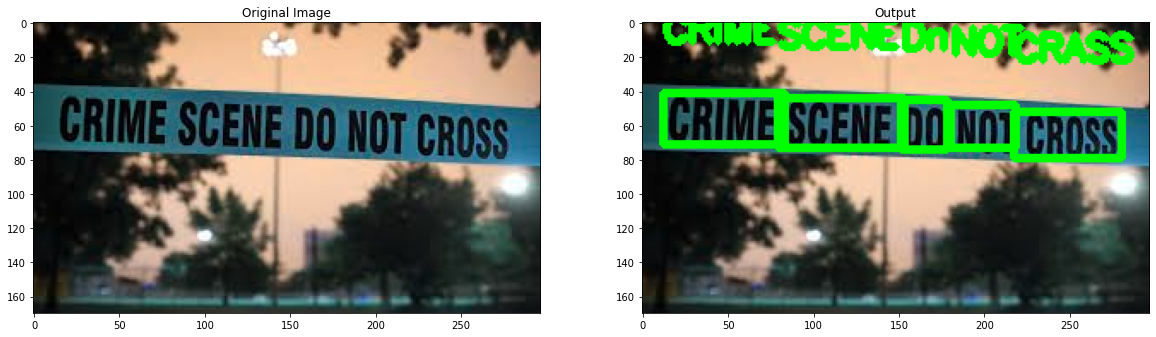

In [221]:
detection_and_recognition_one_images(img_path=image_paths[3])


P




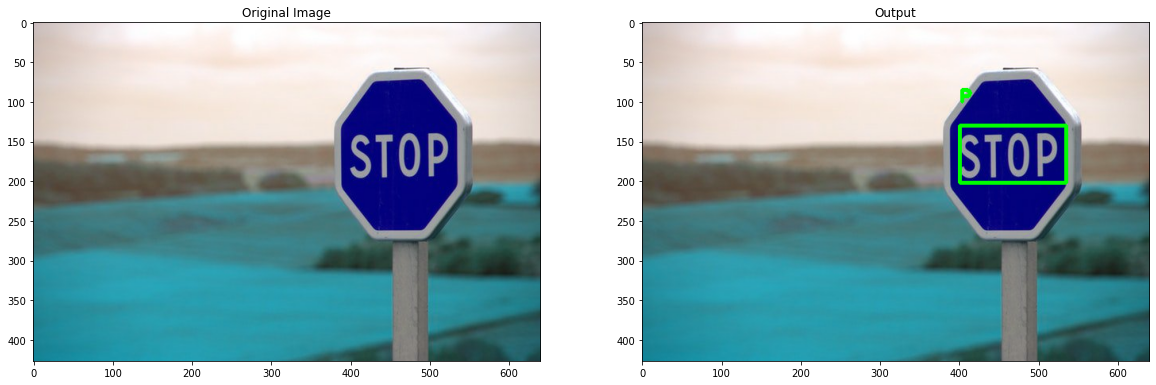

In [222]:
detection_and_recognition_one_images(img_path=image_paths[4])


CaUTDRON




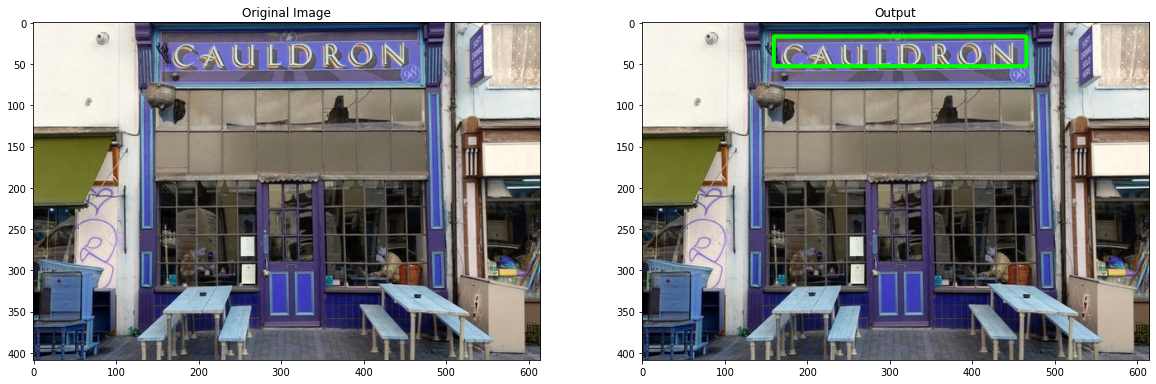

In [223]:
detection_and_recognition_one_images(img_path=image_paths[5])

References:
* https://nanonets.com/blog/deep-learning-ocr/
* https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
* https://www.kaggle.com/mlwhiz/text-detection